In [ ]:
import os
import cv2
import torch
import pandas as pd
import numpy as np
import albumentations as A
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import CLIPProcessor, CLIPModel, BertModel, BertTokenizer, get_linear_schedule_with_warmup
from sklearn.metrics import accuracy_score, f1_score, classification_report
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/memo_3/memotion3/memotion3/train.csv')

In [ ]:
train_df['overall'] = train_df['overall'].replace({
                                                            'very_positive': 2,
                                                            'positive': 2,
                                                            'neutral': 1,
                                                            'very_negative': 0,
                                                            'negative': 0})

/tmp/ipython-input-3740866416.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_df['overall'] = train_df['overall'].replace({


In [ ]:
val_df = pd.read_csv('/content/drive/MyDrive/memo_3/val.csv')

In [ ]:
val_df['overall'] = val_df['overall'].replace({
                                                            'very_positive': 2,
                                                            'positive': 2,
                                                            'neutral': 1,
                                                            'very_negative': 0,
                                                            'negative': 0})

/tmp/ipython-input-2159871312.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  val_df['overall'] = val_df['overall'].replace({


In [ ]:
# !pip install text_hammer

In [ ]:
import text_hammer as th

In [ ]:
%%time

from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()

def text_preprocessing(df, col_name):
  column = col_name
  df[column] = df[column].progress_apply(lambda x:str(x).lower())
  df[column] = df[column].progress_apply(lambda x: th.cont_exp(x)) # you're -> you are; we'll be -> we will be
  df[column] = df[column].progress_apply(lambda x: th.remove_emails(x))
  df[column] = df[column].progress_apply(lambda x: th.remove_html_tags(x))

  df[column] = df[column].progress_apply(lambda x: th.remove_special_chars(x))
  df[column] = df[column].progress_apply(lambda x: th.remove_accented_chars(x))

  return df

CPU times: user 570 µs, sys: 112 µs, total: 682 µs
Wall time: 691 µs


In [ ]:
train_dataset = text_preprocessing(train_df, 'ocr')
val_dataset = text_preprocessing(val_df, 'ocr')

In [ ]:
train_dataset.head()

,Unnamed: 0,image_url,humour,sarcastic,offensive,motivational,overall,ocr
0,0,https://encrypted-tbn0.gstatic.com/images?q=tb...,very_funny,twisted_meaning,not_offensive,not_motivational,1,relationship statussinglemarriedit is complica...
1,1,https://encrypted-tbn0.gstatic.com/images?q=tb...,very_funny,twisted_meaning,slight,not_motivational,1,bernie or reaganbe informed compare them on th...
2,2,https://encrypted-tbn0.gstatic.com/images?q=tb...,funny,general,not_offensive,not_motivational,2,i hear somethingbetter run a mileoh my god raj...
3,3,https://preview.redd.it/iwcz3o2niix61.jpg?widt...,very_funny,twisted_meaning,not_offensive,not_motivational,2,redditors visiting ig memepagesdies from cring...
4,4,https://encrypted-tbn0.gstatic.com/images?q=tb...,not_funny,not_sarcastic,very_offensive,not_motivational,0,samajh nahi aaya par sun ke acabobudget speech...


In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import CLIPModel, CLIPProcessor, BertTokenizer, BertModel, get_linear_schedule_with_warmup
import albumentations as A
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
from torch.cuda.amp import autocast, GradScaler

In [ ]:
# ===================== Dataset Class =====================
class MemeDataset(Dataset):
    def __init__(self, images, captions, sentiments, tokenizer, image_transforms, image_dir):
        self.images = images
        self.captions = captions
        self.sentiments = sentiments
        self.tokenizer = tokenizer
        self.image_transforms = image_transforms
        self.image_dir = image_dir

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_name = self.images[idx]
        image_path = os.path.join(self.image_dir, image_name)
        caption = self.captions[idx]
        sentiment = self.sentiments[idx]

        # Load and preprocess image with proper error handling
        try:
            image = Image.open(image_path).convert('RGB')
            image = np.array(image)
        except Exception as e:
            # print(f"Error loading {image_path}: {e}")
            image = np.full((224, 224, 3), 128, dtype=np.uint8)

        # Apply transforms
        image = self.image_transforms(image=image)['image']
        image = torch.tensor(image).permute(2, 0, 1).float()

        # Ensure caption is a valid string
        if not isinstance(caption, str):
            caption = str(caption) if caption else "empty caption"
        if isinstance(caption, list):
            caption = ' '.join(caption)
        if not caption or caption.strip() == '':
            caption = "empty caption"

        # Encode caption
        encoded_caption = self.tokenizer(
            caption,
            return_tensors="pt",
            padding='max_length',
            truncation=True,
            max_length=77
        )
        input_ids = encoded_caption['input_ids'].squeeze()
        attention_mask = encoded_caption['attention_mask'].squeeze()

        sentiment_class = torch.tensor(sentiment, dtype=torch.long)

        return {
            'image': image,
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'sentiment': sentiment_class
        }


# ===================== Gated Multimodal Fusion Module =====================
class GatedMultimodalFusion(nn.Module):
    """
    Gated fusion that learns to dynamically weight image and text features.
    Uses learnable gates to control modality importance.
    """
    def __init__(self, embed_dim, dropout=0.1):
        super(GatedMultimodalFusion, self).__init__()

        # Attention-based pooling (better than mean pooling)
        self.image_pooling = nn.Sequential(
            nn.Linear(embed_dim, embed_dim),
            nn.Tanh(),
            nn.Linear(embed_dim, 1)
        )

        self.text_pooling = nn.Sequential(
            nn.Linear(embed_dim, embed_dim),
            nn.Tanh(),
            nn.Linear(embed_dim, 1)
        )

        # Gate network - learns to balance modalities
        self.gate = nn.Sequential(
            nn.Linear(embed_dim * 2, embed_dim),
            nn.LayerNorm(embed_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(embed_dim, embed_dim),
            nn.Sigmoid()  # Output between 0 and 1
        )

        # Transformation layers for each modality
        self.image_transform = nn.Sequential(
            nn.Linear(embed_dim, embed_dim),
            nn.LayerNorm(embed_dim),
            nn.GELU(),
            nn.Dropout(dropout)
        )

        self.text_transform = nn.Sequential(
            nn.Linear(embed_dim, embed_dim),
            nn.LayerNorm(embed_dim),
            nn.GELU(),
            nn.Dropout(dropout)
        )

        # Final fusion layer
        self.fusion_layer = nn.Sequential(
            nn.Linear(embed_dim * 2, embed_dim * 2),
            nn.LayerNorm(embed_dim * 2),
            nn.GELU(),
            nn.Dropout(dropout)
        )

    def forward(self, image_feats, text_feats):
        """
        Args:
            image_feats: [B, seq_i, D] - Image patch features
            text_feats: [B, seq_t, D] - Text token features
        Returns:
            fused_features: [B, 2*D] - Concatenated gated features
            image_pooled: [B, D] - Pooled image features
            text_pooled: [B, D] - Pooled text features
        """
        # Attention-based pooling
        image_weights = F.softmax(self.image_pooling(image_feats), dim=1)  # [B, seq_i, 1]
        image_pooled = (image_feats * image_weights).sum(dim=1)  # [B, D]

        text_weights = F.softmax(self.text_pooling(text_feats), dim=1)  # [B, seq_t, 1]
        text_pooled = (text_feats * text_weights).sum(dim=1)  # [B, D]

        # Transform features
        image_transformed = self.image_transform(image_pooled)  # [B, D]
        text_transformed = self.text_transform(text_pooled)  # [B, D]

        # Compute gate values based on both modalities
        combined = torch.cat([image_transformed, text_transformed], dim=1)  # [B, 2*D]
        gate_values = self.gate(combined)  # [B, D] - values between 0 and 1

        # Apply gating: gate controls image importance, (1-gate) controls text importance
        gated_image = gate_values * image_transformed  # [B, D]
        gated_text = (1 - gate_values) * text_transformed  # [B, D]

        # Combine gated features
        fused = torch.cat([gated_image, gated_text], dim=1)  # [B, 2*D]
        fused_features = self.fusion_layer(fused)  # [B, 2*D]

        return fused_features, image_pooled, text_pooled


# ===================== Enhanced Loss Function =====================
class EnhancedLoss(nn.Module):
    def __init__(self, contrastive_weight=0.1, temperature=0.07):
        super(EnhancedLoss, self).__init__()
        self.ce_loss = nn.CrossEntropyLoss()
        self.contrastive_weight = contrastive_weight
        self.temperature = temperature

    def forward(self, logits, labels, image_feats, text_feats):
        # Classification loss
        ce_loss = self.ce_loss(logits, labels)

        # Contrastive alignment loss (image-text alignment)
        image_feats_norm = F.normalize(image_feats, dim=-1)
        text_feats_norm = F.normalize(text_feats, dim=-1)

        # Cosine similarity matrix
        similarity = torch.matmul(image_feats_norm, text_feats_norm.T) / self.temperature

        # Contrastive loss (InfoNCE)
        batch_size = image_feats.size(0)
        labels_contrastive = torch.arange(batch_size).to(image_feats.device)

        contrastive_loss = (
            F.cross_entropy(similarity, labels_contrastive) +
            F.cross_entropy(similarity.T, labels_contrastive)
        ) / 2

        total_loss = ce_loss + self.contrastive_weight * contrastive_loss

        return total_loss, ce_loss, contrastive_loss


# ===================== Main Model with Gated Fusion =====================
class CustomCLIPBERTModelGated(nn.Module):
    """
    CLIP-BERT model using Gated Multimodal Fusion.
    """
    def __init__(self, clip_model, bert_model, freeze_strategy='freeze_all'):
        """
        Args:
            freeze_strategy: 'freeze_all', 'freeze_early', or 'train_all'
        """
        super(CustomCLIPBERTModelGated, self).__init__()
        self.clip_model = clip_model
        self.bert_model = bert_model

        # Apply freezing strategy
        if freeze_strategy == 'freeze_all':
            # RECOMMENDED: Freeze all CLIP and BERT layers
            print("Freezing ALL CLIP and BERT layers (only training fusion + classifier)")
            for param in self.clip_model.parameters():
                param.requires_grad = False
            for param in self.bert_model.parameters():
                param.requires_grad = False

        elif freeze_strategy == 'freeze_early':
            # Freeze early layers, train late layers
            print("Freezing early layers of CLIP and BERT (training top 3 layers + fusion + classifier)")
            # Freeze CLIP early layers
            for name, param in self.clip_model.named_parameters():
                if 'encoder.layers' in name:
                    layer_num = int(name.split('encoder.layers.')[1].split('.')[0])
                    if layer_num < 9:  # Freeze first 9 of 12 layers
                        param.requires_grad = False
                    else:
                        param.requires_grad = True
                else:
                    param.requires_grad = False  # Freeze embeddings

            # Freeze BERT early layers
            for name, param in self.bert_model.named_parameters():
                if 'encoder.layer' in name:
                    layer_num = int(name.split('encoder.layer.')[1].split('.')[0])
                    if layer_num < 9:  # Freeze first 9 of 12 layers
                        param.requires_grad = False
                    else:
                        param.requires_grad = True
                else:
                    param.requires_grad = False  # Freeze embeddings

        elif freeze_strategy == 'train_all':
            # Train everything (NOT RECOMMENDED for small datasets)
            print("Training ALL layers (WARNING: High overfitting risk on small datasets)")
            for param in self.clip_model.parameters():
                param.requires_grad = True
            for param in self.bert_model.parameters():
                param.requires_grad = True
        else:
            raise ValueError(f"Unknown freeze_strategy: {freeze_strategy}")

        # Project CLIP vision features to BERT dimension (768)
        self.image_proj = nn.Sequential(
            nn.Linear(768, 768),
            nn.LayerNorm(768),
            nn.GELU()
        )

        # Gated Multimodal Fusion
        self.gated_fusion = GatedMultimodalFusion(embed_dim=768, dropout=0.1)

        # Enhanced Classifier head with BatchNorm and higher dropout
        self.fc1 = nn.Linear(768 * 2, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.dropout1 = nn.Dropout(0.5)

        self.fc2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.dropout2 = nn.Dropout(0.4)

        self.fc3 = nn.Linear(256, 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.dropout3 = nn.Dropout(0.4)

        self.fc4 = nn.Linear(128, 3)
        self.gelu = nn.GELU()

    def forward(self, image, input_ids, attention_mask):
        # Extract CLIP vision features (patch embeddings)
        vision_outputs = self.clip_model.vision_model(pixel_values=image)
        image_features = vision_outputs.last_hidden_state  # [B, 50, 768]
        image_features = self.image_proj(image_features)

        # Extract BERT text features
        bert_output = self.bert_model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            output_hidden_states=True
        )
        text_features = bert_output.last_hidden_state  # [B, seq_len, 768]

        # Gated fusion
        fused_features, image_pooled, text_pooled = self.gated_fusion(
            image_features, text_features
        )

        # Classification with BatchNorm
        x = self.fc1(fused_features)
        x = self.bn1(x)
        x = self.gelu(x)
        x = self.dropout1(x)

        x = self.fc2(x)
        x = self.bn2(x)
        x = self.gelu(x)
        x = self.dropout2(x)

        x = self.fc3(x)
        x = self.bn3(x)
        x = self.gelu(x)
        x = self.dropout3(x)

        logits = self.fc4(x)

        return logits, image_pooled, text_pooled


# ===================== Utility Classes =====================
class AvgMeter:
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']


# ===================== Training Function =====================
def train_epoch(model, train_loader, optimizer, scheduler, device, criterion, scaler=None):
    model.train()
    loss_meter = AvgMeter()
    ce_loss_meter = AvgMeter()
    contrastive_loss_meter = AvgMeter()
    correct_predictions = 0
    total_predictions = 0

    tqdm_object = tqdm(train_loader, total=len(train_loader))

    for batch in tqdm_object:
        images = batch['image'].to(device)
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        sentiments = batch['sentiment'].to(device)

        optimizer.zero_grad()

        # Mixed precision training
        if scaler is not None:
            with autocast():
                logits, image_feats, text_feats = model(images, input_ids, attention_mask)
                loss, ce_loss, contrastive_loss = criterion(
                    logits, sentiments, image_feats, text_feats
                )

            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            scaler.step(optimizer)
            scaler.update()
        else:
            logits, image_feats, text_feats = model(images, input_ids, attention_mask)
            loss, ce_loss, contrastive_loss = criterion(
                logits, sentiments, image_feats, text_feats
            )
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

        scheduler.step()

        count = images.size(0)
        loss_meter.update(loss.item(), count)
        ce_loss_meter.update(ce_loss.item(), count)
        contrastive_loss_meter.update(contrastive_loss.item(), count)

        preds = logits.argmax(dim=1)
        correct_predictions += (preds == sentiments).sum().item()
        total_predictions += sentiments.size(0)

        tqdm_object.set_postfix(
            train_loss=loss_meter.avg,
            ce_loss=ce_loss_meter.avg,
            contrast_loss=contrastive_loss_meter.avg,
            lr=get_lr(optimizer)
        )

    accuracy = correct_predictions / total_predictions
    return loss_meter, ce_loss_meter, contrastive_loss_meter, accuracy


# ===================== Evaluation Function =====================
def evaluate(model, data_loader, device, criterion):
    model.eval()
    predictions, true_labels = [], []
    loss_meter = AvgMeter()
    ce_loss_meter = AvgMeter()
    contrastive_loss_meter = AvgMeter()
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for batch in data_loader:
            images = batch['image'].to(device)
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            sentiments = batch['sentiment'].to(device)

            logits, image_feats, text_feats = model(images, input_ids, attention_mask)
            loss, ce_loss, contrastive_loss = criterion(
                logits, sentiments, image_feats, text_feats
            )

            loss_meter.update(loss.item(), len(images))
            ce_loss_meter.update(ce_loss.item(), len(images))
            contrastive_loss_meter.update(contrastive_loss.item(), len(images))

            preds = logits.argmax(dim=1)
            correct_predictions += (preds == sentiments).sum().item()
            total_predictions += sentiments.size(0)

            predictions.extend(preds.cpu().numpy())
            true_labels.extend(sentiments.cpu().numpy())

    accuracy = correct_predictions / total_predictions
    return predictions, true_labels, loss_meter.avg, ce_loss_meter.avg, contrastive_loss_meter.avg, accuracy


# ===================== Visualization Functions =====================
def plot_training_history(train_losses, val_losses, train_accuracies, val_accuracies):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Loss plot
    ax1.plot(train_losses, label='Train Loss', marker='o')
    ax1.plot(val_losses, label='Val Loss', marker='s')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.legend()
    ax1.grid(True)

    # Accuracy plot
    ax2.plot(train_accuracies, label='Train Accuracy', marker='o')
    ax2.plot(val_accuracies, label='Val Accuracy', marker='s')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Training and Validation Accuracy')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.savefig('training_history_gated.png', dpi=300, bbox_inches='tight')
    plt.show()


def plot_confusion_matrix(true_labels, predictions, class_names=['Negative', 'Neutral', 'Positive']):
    cm = confusion_matrix(true_labels, predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix - Gated Fusion')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.savefig('confusion_matrix_gated.png', dpi=300, bbox_inches='tight')
    plt.show()


# ===================== Main Training Script =====================
# Set device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

# Data augmentation
train_image_transforms = A.Compose([
    A.Resize(224, 224),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.3),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, p=0.5),
    A.CoarseDropout(max_holes=8, max_height=16, max_width=16, p=0.2),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

val_image_transforms = A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

# Load models
print("Loading CLIP and BERT models...")
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

# Create model with GATED FUSION
print("\nCreating model with Gated Multimodal Fusion...")

# For 7k dataset with unfrozen layers, use 'freeze_early' as compromise
# If you want full training, be prepared for 20-30 epochs
model = CustomCLIPBERTModelGated(
    clip_model,
    bert_model,
    freeze_strategy='train_all'  # Changed to train_all based on your decision
)
model = model.to(device)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\nModel Statistics:")
print(f"  Total parameters:     {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,} ({trainable_params/total_params*100:.2f}%)")
print(f"  Frozen parameters:    {total_params-trainable_params:,} ({(total_params-trainable_params)/total_params*100:.2f}%)")

# Warning for small datasets
if trainable_params > 50_000_000:  # 50M+ trainable params
    print(f"\n⚠️  WARNING: Training {trainable_params:,} parameters on 7k samples")
    print(f"   Recommendation: Use 20-30 epochs or consider 'freeze_early' strategy")

# Dataset paths (update these to your actual paths)
train_image_dir = '/content/drive/MyDrive/memo_3/trainImages/trainImages'
val_image_dir = '/content/drive/MyDrive/memo_3/valImages/valImages'

# Create datasets - REPLACE train_df and val_df with your actual DataFrames
train_dataset = MemeDataset(
    images=train_df['image_url'].tolist(),
    captions=train_df['ocr'].tolist(),
    sentiments=train_df['overall'].tolist(),
    tokenizer=bert_tokenizer,
    image_transforms=train_image_transforms,
    image_dir=train_image_dir
)

val_dataset = MemeDataset(
    images=val_df['image_url'].tolist(),
    captions=val_df['ocr'].tolist(),
    sentiments=val_df['overall'].tolist(),
    tokenizer=bert_tokenizer,
    image_transforms=val_image_transforms,
    image_dir=val_image_dir
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

# Discriminative learning rates (adjusted for unfrozen layers)
# Use VERY LOW learning rates for pretrained models to prevent catastrophic forgetting
trainable_params = []

# CLIP parameters - VERY LOW LR to preserve pretrained knowledge
clip_params = [p for p in model.clip_model.parameters() if p.requires_grad]
if clip_params:
    trainable_params.append({'params': clip_params, 'lr': 5e-7})  # Reduced from 1e-6

# BERT parameters - VERY LOW LR to preserve pretrained knowledge
bert_params = [p for p in model.bert_model.parameters() if p.requires_grad]
if bert_params:
    trainable_params.append({'params': bert_params, 'lr': 5e-7})  # Reduced from 1e-6

# New layers can have higher LR
trainable_params.extend([
    {'params': model.image_proj.parameters(), 'lr': 1e-4},
    {'params': model.gated_fusion.parameters(), 'lr': 1e-4},
    # Classifier layers (individual fc layers, bn layers, etc.)
    {'params': model.fc1.parameters(), 'lr': 1e-4},
    {'params': model.bn1.parameters(), 'lr': 1e-4},
    {'params': model.fc2.parameters(), 'lr': 1e-4},
    {'params': model.bn2.parameters(), 'lr': 1e-4},
    {'params': model.fc3.parameters(), 'lr': 1e-4},
    {'params': model.bn3.parameters(), 'lr': 1e-4},
    {'params': model.fc4.parameters(), 'lr': 1e-4},
])

optimizer = torch.optim.AdamW(trainable_params, weight_decay=1e-4)

# INCREASED epochs for full training (was 10, now 25)
num_epochs = 25

print(f"\nTraining Configuration:")
print(f"  Number of epochs: {num_epochs}")
print(f"  Batch size: 32")
print(f"  Total training steps: {len(train_loader) * num_epochs:,}")
print(f"  Warmup steps: {len(train_loader) * 3:,} (3 epochs)")

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=len(train_loader) * 3,  # 3 epochs warmup (was 2)
    num_training_steps=len(train_loader) * num_epochs
)

# Loss function
criterion = EnhancedLoss(contrastive_weight=0.1, temperature=0.07)

# Mixed precision training
scaler = GradScaler() if device == 'cuda' else None

# Training tracking
BEST_MODEL_PATH = 'best_model_gated.pth'
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
best_val_accuracy = 0
patience = 5  # Increased from 3 for longer training
patience_counter = 0

print("\n" + "="*70)
print("STARTING TRAINING WITH GATED MULTIMODAL FUSION")
print("="*70)

for epoch in range(num_epochs):
    print(f"\n{'='*50}")
    print(f"Epoch {epoch + 1}/{num_epochs}")
    print(f"{'='*50}")

    # Train
    train_loss, train_ce, train_contrast, train_accuracy = train_epoch(
        model, train_loader, optimizer, scheduler, device, criterion, scaler
    )

    # Validate
    val_predictions, val_true_labels, val_loss, val_ce, val_contrast, val_accuracy = evaluate(
        model, val_loader, device, criterion
    )

    # Save best model
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_accuracy': val_accuracy,
        }, BEST_MODEL_PATH)
        print(f"✓ Best model saved with validation accuracy: {val_accuracy:.4f}")
        patience_counter = 0
    else:
        patience_counter += 1

    # Store metrics
    train_losses.append(train_loss.avg)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    # Print epoch summary
    print(f"\nEpoch {epoch + 1} Summary:")
    print(f"  Train Loss: {train_loss.avg:.4f} (CE: {train_ce.avg:.4f}, Contrast: {train_contrast.avg:.4f})")
    print(f"  Train Accuracy: {train_accuracy:.4f}")
    print(f"  Val Loss: {val_loss:.4f} (CE: {val_ce:.4f}, Contrast: {val_contrast:.4f})")
    print(f"  Val Accuracy: {val_accuracy:.4f}")
    print(f"  Best Val Accuracy: {best_val_accuracy:.4f}")

    # Early stopping
    # if patience_counter >= patience:
    #     print(f"\nEarly stopping triggered after {epoch + 1} epochs")
    #     break

# Load best model
print(f"\nLoading best model with validation accuracy: {best_val_accuracy:.4f}")
checkpoint = torch.load(BEST_MODEL_PATH)
model.load_state_dict(checkpoint['model_state_dict'])

Using device: cuda
Loading CLIP and BERT models...


/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/tmp/ipython-input-1956123676.py:482: UserWarning: Argument(s) 'max_holes, max_height, max_width' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=8, max_height=16, max_width=16, p=0.2),
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(



Creating model with Gated Multimodal Fusion...
Training ALL layers (WARNING: High overfitting risk on small datasets)


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-1956123676.py:597: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler() if device == 'cuda' else None



Model Statistics:
  Total parameters:     268,808,454
  Trainable parameters: 268,808,454 (100.00%)
  Frozen parameters:    0 (0.00%)

⚠️  WARNING: Training 268,808,454 parameters on 7k samples
   Recommendation: Use 20-30 epochs or consider 'freeze_early' strategy

Training Configuration:
  Number of epochs: 25
  Batch size: 32
  Total training steps: 5,475
  Warmup steps: 657 (3 epochs)

STARTING TRAINING WITH GATED MULTIMODAL FUSION

Epoch 1/25


  0%|          | 0/219 [00:00<?, ?it/s]/tmp/ipython-input-1956123676.py:353: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 219/219 [01:06<00:00,  3.29it/s, ce_loss=1.18, contrast_loss=3.48, lr=1.67e-7, train_loss=1.53]


✓ Best model saved with validation accuracy: 0.2568

Epoch 1 Summary:
  Train Loss: 1.5263 (CE: 1.1783, Contrast: 3.4794)
  Train Accuracy: 0.3179
  Val Loss: 1.4680 (CE: 1.1206, Contrast: 3.4741)
  Val Accuracy: 0.2568
  Best Val Accuracy: 0.2568

Epoch 2/25


100%|██████████| 219/219 [01:09<00:00,  3.16it/s, ce_loss=1.14, contrast_loss=3.48, lr=3.33e-7, train_loss=1.48]


✓ Best model saved with validation accuracy: 0.3069

Epoch 2 Summary:
  Train Loss: 1.4837 (CE: 1.1362, Contrast: 3.4750)
  Train Accuracy: 0.3593
  Val Loss: 1.4594 (CE: 1.1122, Contrast: 3.4717)
  Val Accuracy: 0.3069
  Best Val Accuracy: 0.3069

Epoch 3/25


100%|██████████| 219/219 [01:13<00:00,  2.96it/s, ce_loss=1.11, contrast_loss=3.47, lr=5e-7, train_loss=1.46]


✓ Best model saved with validation accuracy: 0.3389

Epoch 3 Summary:
  Train Loss: 1.4588 (CE: 1.1117, Contrast: 3.4715)
  Train Accuracy: 0.3883
  Val Loss: 1.4541 (CE: 1.1070, Contrast: 3.4706)
  Val Accuracy: 0.3389
  Best Val Accuracy: 0.3389

Epoch 4/25


100%|██████████| 219/219 [01:13<00:00,  2.98it/s, ce_loss=1.1, contrast_loss=3.47, lr=4.77e-7, train_loss=1.45]


✓ Best model saved with validation accuracy: 0.3562

Epoch 4 Summary:
  Train Loss: 1.4471 (CE: 1.0997, Contrast: 3.4738)
  Train Accuracy: 0.3953
  Val Loss: 1.4791 (CE: 1.1320, Contrast: 3.4709)
  Val Accuracy: 0.3562
  Best Val Accuracy: 0.3562

Epoch 5/25


100%|██████████| 219/219 [01:06<00:00,  3.28it/s, ce_loss=1.08, contrast_loss=3.47, lr=4.55e-7, train_loss=1.43]



Epoch 5 Summary:
  Train Loss: 1.4298 (CE: 1.0825, Contrast: 3.4733)
  Train Accuracy: 0.4173
  Val Loss: 1.4899 (CE: 1.1428, Contrast: 3.4709)
  Val Accuracy: 0.3489
  Best Val Accuracy: 0.3562

Epoch 6/25


100%|██████████| 219/219 [01:06<00:00,  3.27it/s, ce_loss=1.06, contrast_loss=3.47, lr=4.32e-7, train_loss=1.41]



Epoch 6 Summary:
  Train Loss: 1.4122 (CE: 1.0649, Contrast: 3.4731)
  Train Accuracy: 0.4317
  Val Loss: 1.5031 (CE: 1.1561, Contrast: 3.4700)
  Val Accuracy: 0.3502
  Best Val Accuracy: 0.3562

Epoch 7/25


100%|██████████| 219/219 [01:06<00:00,  3.29it/s, ce_loss=1.05, contrast_loss=3.47, lr=4.09e-7, train_loss=1.4]



Epoch 7 Summary:
  Train Loss: 1.3950 (CE: 1.0478, Contrast: 3.4724)
  Train Accuracy: 0.4476
  Val Loss: 1.4954 (CE: 1.1483, Contrast: 3.4710)
  Val Accuracy: 0.3542
  Best Val Accuracy: 0.3562

Epoch 8/25


100%|██████████| 219/219 [01:06<00:00,  3.28it/s, ce_loss=1.04, contrast_loss=3.47, lr=3.86e-7, train_loss=1.39]



Epoch 8 Summary:
  Train Loss: 1.3862 (CE: 1.0390, Contrast: 3.4723)
  Train Accuracy: 0.4620
  Val Loss: 1.5207 (CE: 1.1737, Contrast: 3.4693)
  Val Accuracy: 0.3556
  Best Val Accuracy: 0.3562

Epoch 9/25


100%|██████████| 219/219 [01:10<00:00,  3.09it/s, ce_loss=1.02, contrast_loss=3.47, lr=3.64e-7, train_loss=1.37]



Epoch 9 Summary:
  Train Loss: 1.3715 (CE: 1.0243, Contrast: 3.4721)
  Train Accuracy: 0.4761
  Val Loss: 1.5207 (CE: 1.1737, Contrast: 3.4698)
  Val Accuracy: 0.3562
  Best Val Accuracy: 0.3562

Epoch 10/25


100%|██████████| 219/219 [01:06<00:00,  3.32it/s, ce_loss=1.01, contrast_loss=3.47, lr=3.41e-7, train_loss=1.36]



Epoch 10 Summary:
  Train Loss: 1.3572 (CE: 1.0100, Contrast: 3.4721)
  Train Accuracy: 0.4903
  Val Loss: 1.5362 (CE: 1.1893, Contrast: 3.4688)
  Val Accuracy: 0.3442
  Best Val Accuracy: 0.3562

Epoch 11/25


100%|██████████| 219/219 [01:09<00:00,  3.14it/s, ce_loss=0.994, contrast_loss=3.47, lr=3.18e-7, train_loss=1.34]



Epoch 11 Summary:
  Train Loss: 1.3409 (CE: 0.9938, Contrast: 3.4712)
  Train Accuracy: 0.5007
  Val Loss: 1.5494 (CE: 1.2025, Contrast: 3.4689)
  Val Accuracy: 0.3436
  Best Val Accuracy: 0.3562

Epoch 12/25


100%|██████████| 219/219 [01:06<00:00,  3.28it/s, ce_loss=0.976, contrast_loss=3.47, lr=2.95e-7, train_loss=1.32]



Epoch 12 Summary:
  Train Loss: 1.3231 (CE: 0.9761, Contrast: 3.4703)
  Train Accuracy: 0.5139
  Val Loss: 1.5446 (CE: 1.1977, Contrast: 3.4684)
  Val Accuracy: 0.3476
  Best Val Accuracy: 0.3562

Epoch 13/25


100%|██████████| 219/219 [01:06<00:00,  3.30it/s, ce_loss=0.969, contrast_loss=3.47, lr=2.73e-7, train_loss=1.32]



Epoch 13 Summary:
  Train Loss: 1.3159 (CE: 0.9688, Contrast: 3.4705)
  Train Accuracy: 0.5221
  Val Loss: 1.5636 (CE: 1.2168, Contrast: 3.4682)
  Val Accuracy: 0.3522
  Best Val Accuracy: 0.3562

Epoch 14/25


100%|██████████| 219/219 [01:05<00:00,  3.32it/s, ce_loss=0.951, contrast_loss=3.47, lr=2.5e-7, train_loss=1.3]



Epoch 14 Summary:
  Train Loss: 1.2983 (CE: 0.9511, Contrast: 3.4712)
  Train Accuracy: 0.5386
  Val Loss: 1.5840 (CE: 1.2372, Contrast: 3.4682)
  Val Accuracy: 0.3522
  Best Val Accuracy: 0.3562

Epoch 15/25


100%|██████████| 219/219 [01:07<00:00,  3.24it/s, ce_loss=0.926, contrast_loss=3.47, lr=2.27e-7, train_loss=1.27]



Epoch 15 Summary:
  Train Loss: 1.2730 (CE: 0.9259, Contrast: 3.4704)
  Train Accuracy: 0.5481
  Val Loss: 1.6151 (CE: 1.2683, Contrast: 3.4681)
  Val Accuracy: 0.3396
  Best Val Accuracy: 0.3562

Epoch 16/25


100%|██████████| 219/219 [01:49<00:00,  2.00it/s, ce_loss=0.9, contrast_loss=3.47, lr=2.05e-7, train_loss=1.25]



Epoch 16 Summary:
  Train Loss: 1.2471 (CE: 0.9001, Contrast: 3.4702)
  Train Accuracy: 0.5784
  Val Loss: 1.6170 (CE: 1.2702, Contrast: 3.4679)
  Val Accuracy: 0.3529
  Best Val Accuracy: 0.3562

Epoch 17/25


100%|██████████| 219/219 [01:08<00:00,  3.17it/s, ce_loss=0.867, contrast_loss=3.47, lr=1.82e-7, train_loss=1.21]



Epoch 17 Summary:
  Train Loss: 1.2138 (CE: 0.8668, Contrast: 3.4700)
  Train Accuracy: 0.5914
  Val Loss: 1.6455 (CE: 1.2987, Contrast: 3.4679)
  Val Accuracy: 0.3322
  Best Val Accuracy: 0.3562

Epoch 18/25


100%|██████████| 219/219 [01:07<00:00,  3.27it/s, ce_loss=0.838, contrast_loss=3.47, lr=1.59e-7, train_loss=1.18]



Epoch 18 Summary:
  Train Loss: 1.1850 (CE: 0.8380, Contrast: 3.4699)
  Train Accuracy: 0.6176
  Val Loss: 1.6921 (CE: 1.3454, Contrast: 3.4673)
  Val Accuracy: 0.3329
  Best Val Accuracy: 0.3562

Epoch 19/25


100%|██████████| 219/219 [01:06<00:00,  3.31it/s, ce_loss=0.817, contrast_loss=3.47, lr=1.36e-7, train_loss=1.16]


✓ Best model saved with validation accuracy: 0.3596

Epoch 19 Summary:
  Train Loss: 1.1636 (CE: 0.8166, Contrast: 3.4698)
  Train Accuracy: 0.6357
  Val Loss: 1.6530 (CE: 1.3062, Contrast: 3.4673)
  Val Accuracy: 0.3596
  Best Val Accuracy: 0.3596

Epoch 20/25


100%|██████████| 219/219 [01:30<00:00,  2.41it/s, ce_loss=0.795, contrast_loss=3.47, lr=1.14e-7, train_loss=1.14]



Epoch 20 Summary:
  Train Loss: 1.1417 (CE: 0.7947, Contrast: 3.4700)
  Train Accuracy: 0.6426
  Val Loss: 1.7064 (CE: 1.3597, Contrast: 3.4673)
  Val Accuracy: 0.3336
  Best Val Accuracy: 0.3596

Epoch 21/25


100%|██████████| 219/219 [01:07<00:00,  3.26it/s, ce_loss=0.768, contrast_loss=3.47, lr=9.09e-8, train_loss=1.11]



Epoch 21 Summary:
  Train Loss: 1.1148 (CE: 0.7679, Contrast: 3.4694)
  Train Accuracy: 0.6611
  Val Loss: 1.7166 (CE: 1.3698, Contrast: 3.4674)
  Val Accuracy: 0.3449
  Best Val Accuracy: 0.3596

Epoch 22/25


100%|██████████| 219/219 [01:06<00:00,  3.29it/s, ce_loss=0.746, contrast_loss=3.47, lr=6.82e-8, train_loss=1.09]



Epoch 22 Summary:
  Train Loss: 1.0929 (CE: 0.7460, Contrast: 3.4694)
  Train Accuracy: 0.6780
  Val Loss: 1.7110 (CE: 1.3643, Contrast: 3.4672)
  Val Accuracy: 0.3469
  Best Val Accuracy: 0.3596

Epoch 23/25


100%|██████████| 219/219 [01:07<00:00,  3.25it/s, ce_loss=0.72, contrast_loss=3.47, lr=4.55e-8, train_loss=1.07]



Epoch 23 Summary:
  Train Loss: 1.0672 (CE: 0.7203, Contrast: 3.4696)
  Train Accuracy: 0.6880
  Val Loss: 1.7501 (CE: 1.4034, Contrast: 3.4672)
  Val Accuracy: 0.3442
  Best Val Accuracy: 0.3596

Epoch 24/25


100%|██████████| 219/219 [01:06<00:00,  3.31it/s, ce_loss=0.708, contrast_loss=3.47, lr=2.27e-8, train_loss=1.05]



Epoch 24 Summary:
  Train Loss: 1.0548 (CE: 0.7078, Contrast: 3.4697)
  Train Accuracy: 0.7017
  Val Loss: 1.7432 (CE: 1.3964, Contrast: 3.4672)
  Val Accuracy: 0.3449
  Best Val Accuracy: 0.3596

Epoch 25/25


100%|██████████| 219/219 [01:06<00:00,  3.28it/s, ce_loss=0.688, contrast_loss=3.47, lr=0, train_loss=1.03]



Epoch 25 Summary:
  Train Loss: 1.0349 (CE: 0.6880, Contrast: 3.4695)
  Train Accuracy: 0.7111
  Val Loss: 1.7490 (CE: 1.4023, Contrast: 3.4672)
  Val Accuracy: 0.3482
  Best Val Accuracy: 0.3596

Loading best model with validation accuracy: 0.3596


<All keys matched successfully>

In [ ]:
# Final evaluation
print("\nFinal evaluation on validation set:")
val_predictions, val_true_labels, _, _, _, final_accuracy = evaluate(
    model, val_loader, device, criterion
)

# Calculate F1 scores
f1_macro = f1_score(val_true_labels, val_predictions, average='macro')
f1_weighted = f1_score(val_true_labels, val_predictions, average='weighted')

print(f"\n{'='*70}")
print("FINAL RESULTS - GATED MULTIMODAL FUSION")
print(f"{'='*70}")
print(f"Final Validation Accuracy: {final_accuracy:.4f}")
print(f"F1-Score (Macro):          {f1_macro:.4f}")
print(f"F1-Score (Weighted):       {f1_weighted:.4f}")
print(f"{'='*70}")

print("\nClassification Report:")
print(classification_report(
    val_true_labels,
    val_predictions,
    target_names=['Negative', 'Neutral', 'Positive'],
    digits=4
))

# Plot results
print("\nGenerating visualizations...")
# plot_training_history(train_losses, val_losses, train_accuracies, val_accuracies)
# plot_confusion_matrix(val_true_labels, val_predictions)

print("\n" + "="*70)
print("TRAINING COMPLETE!")
print("="*70)
print(f"Best Model Path: {BEST_MODEL_PATH}")
print(f"Best Validation Accuracy: {best_val_accuracy:.4f}")
print("Visualizations saved: training_history_gated.png, confusion_matrix_gated.png")
print("="*70)


Final evaluation on validation set:

FINAL RESULTS - GATED MULTIMODAL FUSION
Final Validation Accuracy: 0.3596
F1-Score (Macro):          0.3178
F1-Score (Weighted):       0.3349

Classification Report:
              precision    recall  f1-score   support

    Negative     0.4082    0.2069    0.2746       580
     Neutral     0.3793    0.6131    0.4686       579
    Positive     0.2379    0.1882    0.2102       340

    accuracy                         0.3596      1499
   macro avg     0.3418    0.3361    0.3178      1499
weighted avg     0.3584    0.3596    0.3349      1499


Generating visualizations...

TRAINING COMPLETE!
Best Model Path: best_model_gated.pth
Best Validation Accuracy: 0.3596
Visualizations saved: training_history_gated.png, confusion_matrix_gated.png


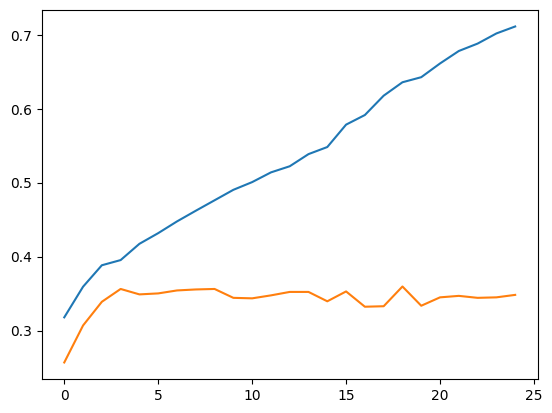

In [ ]:
plt.plot(train_accuracies)
plt.plot(val_accuracies)